## Mutual Information Analyses
- Want to use mutual information to quantify whether a neuron contains information about selected color (or shape or pattern) 
- will then see if color being a rule or not increases information

## Imports, Load Data

In [21]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
from matplotlib import pyplot as plt

EVENT = "FeedbackOnset"  # event in behavior to align on
PRE_INTERVAL = 1300   # time in ms before event
POST_INTERVAL = 1500  # time in ms after event
INTERVAL_SIZE = 100  # size of interval in ms

# the output directory to store the data
OUTPUT_DIR = "/data/patrick_scratch/pseudo"
# path to a dataframe of sessions to analyze
SESSIONS_PATH = "/data/patrick_scratch/multi_sess/valid_sessions_rpe.pickle"
# path for each session, specifying behavior
SESS_BEHAVIOR_PATH = "/data/rawdata/sub-SA/sess-{sess_name}/behavior/sub-SA_sess-{sess_name}_object_features.csv"
# path for each session, for spikes that have been pre-aligned to event time and binned. 
SESS_SPIKES_PATH = "/data/patrick_scratch/multi_sess/{sess_name}/{sess_name}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins.pickle"

DATA_MODE = "SpikeCounts"

NUM_SHUFFLES = 1000
SEED = 42
feature_dims = ["Color", "Shape", "Pattern"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
sess_name = 20180802

behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
beh = pd.read_csv(behavior_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)

# grab the features of the selected card
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
valid_beh = valid_beh.set_index(["TrialNumber"])

spikes_path = SESS_SPIKES_PATH.format(
    sess_name=sess_name, 
    pre_interval=PRE_INTERVAL, 
    event=EVENT, 
    post_interval=POST_INTERVAL, 
    interval_size=INTERVAL_SIZE
)
frs = pd.read_pickle(spikes_path)
frs = frs.set_index(["TrialNumber"])

In [23]:
data = pd.merge(frs, valid_beh, on="TrialNumber")[["UnitID", "TimeBins", "SpikeCounts", "Color", "Shape", "Pattern"]]

In [24]:
def calc_entropy(data):
    """
    Calculates entropy of a given dataset
    """
    _, unique_counts = np.unique(data, return_counts=True)
    probs = unique_counts / len(data)
    entropy = -1 * np.sum(probs * np.log(probs))
    return entropy

def calc_entropy_across_unit_and_time(df, x_column):
    return df.groupby(["UnitID", "TimeBins"]).apply(lambda group: calc_entropy(group[x_column])).to_frame("Entropy")

def calc_conditional_entropy(df, x_column, y_column):
    num_points = len(df)
    per_condition = df.groupby(y_column).apply(
        lambda group: len(group) / num_points * calc_entropy(group[x_column])
    ).to_frame("EntropyPerCond") 
    return per_condition["EntropyPerCond"].sum()


def calc_mutual_information_for_columns(df, x_column, y_columns, h_x=None):
    """
    Calculates mutual information with the relationship:
    I(X; Y) = H(X) - H(X|Y)
    """
    if h_x is None: 
        h_x = calc_entropy(df[x_column])
    mis = []
    for y_column in y_columns:
        h_x_given_y = calc_conditional_entropy(df, x_column, y_column)    
        mis.append(h_x - h_x_given_y)
    return pd.Series({f"MI{y_columns[i]}": mi for i, mi in enumerate(mis)})

def calc_mutual_information_per_unit_and_time(df, x_column, y_columns):
    """
    Calculates mutual information with the relationship:
    I(X; Y) = H(X) - H(X|Y)
    """
    return df.groupby(["UnitID", "TimeBins"]).apply(lambda group: calc_mutual_information_for_columns(group, x_column, y_columns)).reset_index()

## Step 1: Mutual Information between neuron and feature dim
$$ I(r;c) = H(r) - H(r|c) $$ 

In [25]:
data.set_index(["UnitID", "TimeBins"])
mi = calc_mutual_information_per_unit_and_time(data, "SpikeCounts", feature_dims)

In [26]:
mi

,UnitID,TimeBins,MIColor,MIShape,MIPattern
0,0,0.0,0.008826,0.004595,0.006830
1,0,0.1,0.006631,0.007295,0.010343
2,0,0.2,0.006254,0.012116,0.009015
3,0,0.3,0.008235,0.013566,0.007933
4,0,0.4,0.007290,0.008158,0.006805
...,...,...,...,...,...
1283,45,2.3,0.001400,0.003114,0.002807
1284,45,2.4,0.002946,0.001329,0.001788
1285,45,2.5,0.002917,0.001774,0.004629
1286,45,2.6,0.001710,0.001247,0.004035


### Calculate null distributions

In [18]:
shuffle_res = []
shuffled_feature_dims = ["ShuffledColor", "ShuffledShape", "ShuffledPattern"]
rng = np.random.default_rng(SEED)
NUM_SHUFFLES = 5
for i in range(NUM_SHUFFLES):
    for feature_dim in feature_dims:
        labels = valid_beh[feature_dim].values
        rng.shuffle(labels)
        valid_beh[f"Shuffled{feature_dim}"] = labels
    shuffled_data = pd.merge(frs, valid_beh, on="TrialNumber")[["UnitID", "TimeBins", "SpikeCounts"] + shuffled_feature_dims]
    shuffled_data.set_index(["UnitID", "TimeBins"])
    shuffled_mi = calc_mutual_information_per_unit_and_time(shuffled_data, "SpikeCounts", shuffled_feature_dims)
    shuffled_mi["ShuffleIdx"] = i
    shuffle_res.append(shuffled_mi)

In [27]:
# Parallel version of shuffling
from multiprocessing import Pool

In [28]:
def calc_shuffled(i):
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=sess_name)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)

    # grab the features of the selected card
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    valid_beh = valid_beh.set_index(["TrialNumber"])

    spikes_path = SESS_SPIKES_PATH.format(
        sess_name=sess_name, 
        pre_interval=PRE_INTERVAL, 
        event=EVENT, 
        post_interval=POST_INTERVAL, 
        interval_size=INTERVAL_SIZE
    )
    frs = pd.read_pickle(spikes_path)
    frs = frs.set_index(["TrialNumber"])
    for feature_dim in feature_dims:
        labels = valid_beh[feature_dim].values
        rng.shuffle(labels)
        valid_beh[f"Shuffled{feature_dim}"] = labels
    shuffled_data = pd.merge(frs, valid_beh, on="TrialNumber")[["UnitID", "TimeBins", "SpikeCounts"] + shuffled_feature_dims]
    shuffled_data.set_index(["UnitID", "TimeBins"])
    shuffled_mi = calc_mutual_information_per_unit_and_time(shuffled_data, "SpikeCounts", shuffled_feature_dims)
    shuffled_mi["ShuffleIdx"] = i
    return shuffled_mi

In [29]:
with Pool(processes=4) as pool:
    res = pool.map(calc_shuffled, range(3))

In [31]:
shuffled_mi = pd.concat(res)

In [35]:
# calculate stats for shuffled stats
def calculate_shuffled_stats(group):
    row = {}
    for feature_dim in feature_dims:
        vals = group[f"MIShuffled{feature_dim}"]
        row[f"MIShuffled{feature_dim}95th"] = np.percentile(vals, 95)
        row[f"MIShuffled{feature_dim}99th"] = np.percentile(vals, 99)
        row[f"MIShuffled{feature_dim}Mean"] = np.mean(vals)
        row[f"MIShuffled{feature_dim}Std"] = np.std(vals)
    return pd.Series(row)
shuffled_mi.set_index(["UnitID", "TimeBins"])
null_stats = shuffled_mi.groupby(["UnitID", "TimeBins"]).apply(calculate_shuffled_stats).reset_index()

In [36]:
null_stats

,UnitID,TimeBins,MIShuffledColor95th,MIShuffledColor99th,MIShuffledColorMean,MIShuffledColorStd,MIShuffledShape95th,MIShuffledShape99th,MIShuffledShapeMean,MIShuffledShapeStd,MIShuffledPattern95th,MIShuffledPattern99th,MIShuffledPatternMean,MIShuffledPatternStd
0,0,0.0,0.010727,0.010727,0.010727,0.0,0.003973,0.003973,0.003973,0.0,0.010254,0.010254,0.010254,0.0
1,0,0.1,0.009367,0.009367,0.009367,0.0,0.009932,0.009932,0.009932,0.0,0.011109,0.011109,0.011109,0.0
2,0,0.2,0.005639,0.005639,0.005639,0.0,0.007668,0.007668,0.007668,0.0,0.011052,0.011052,0.011052,0.0
3,0,0.3,0.010384,0.010384,0.010384,0.0,0.008100,0.008100,0.008100,0.0,0.009227,0.009227,0.009227,0.0
4,0,0.4,0.009323,0.009323,0.009323,0.0,0.008758,0.008758,0.008758,0.0,0.008060,0.008060,0.008060,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1283,45,2.3,0.001971,0.001971,0.001971,0.0,0.001965,0.001965,0.001965,0.0,0.000913,0.000913,0.000913,0.0
1284,45,2.4,0.001444,0.001444,0.001444,0.0,0.002199,0.002199,0.002199,0.0,0.003554,0.003554,0.003554,0.0
1285,45,2.5,0.000796,0.000796,0.000796,0.0,0.001692,0.001692,0.001692,0.0,0.002041,0.002041,0.002041,0.0
1286,45,2.6,0.001454,0.001454,0.001454,0.0,0.002003,0.002003,0.002003,0.0,0.001697,0.001697,0.001697,0.0


In [15]:
valid_beh.columns

Index(['BlockNumber', 'TrialAfterRuleChange', 'TaskInterrupt',
       'ConditionNumber', 'Response', 'ItemChosen', 'TrialType', 'CurrentRule',
       'LastRule', 'ShiftType', 'Perseveration', 'TrialStart', 'FixCrossOn',
       'FixationOnCross', 'FixRequireEnd', 'StimOnset', 'FeedbackEncode',
       'FeedbackOnset', 'TrialEnd', 'Item0_xPos', 'Item0_yPos', 'Item1_xPos',
       'Item1_yPos', 'Item2_xPos', 'Item2_yPos', 'Item3_xPos', 'Item3_yPos',
       'Item0Shape', 'Item0Color', 'Item0Pattern', 'Item1Shape', 'Item1Color',
       'Item1Pattern', 'Item2Shape', 'Item2Color', 'Item2Pattern',
       'Item3Shape', 'Item3Color', 'Item3Pattern', 'Color', 'Shape', 'Pattern',
       'ShuffledColor'],
      dtype='object')

/tmp/ipykernel_727255/2150634661.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


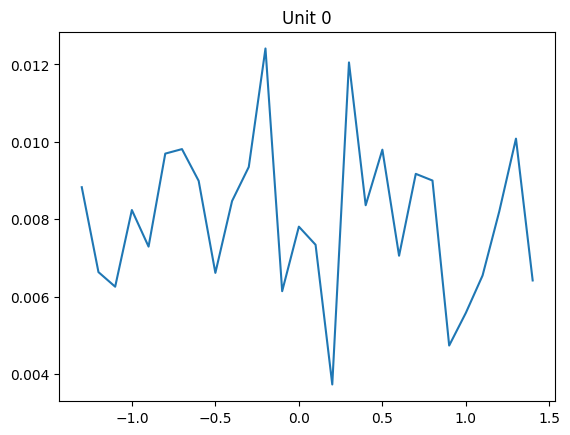

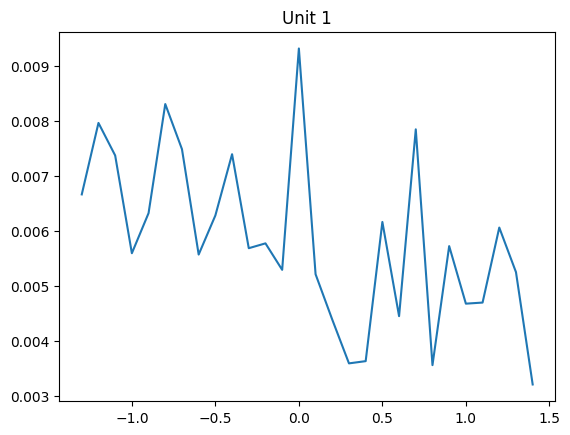

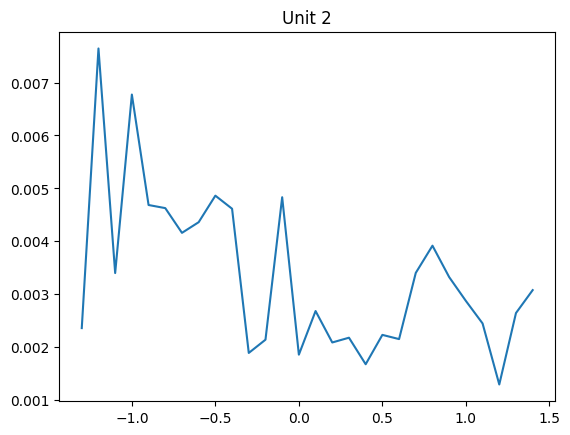

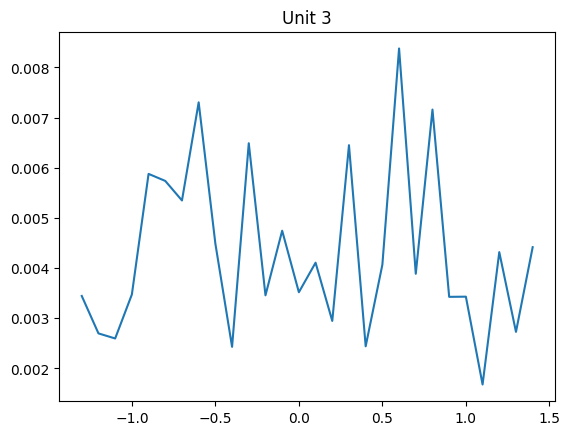

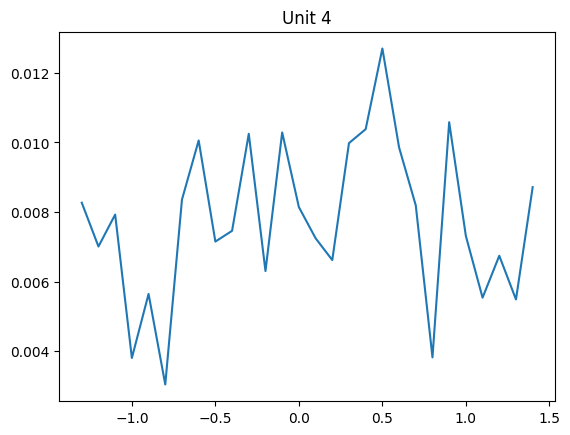

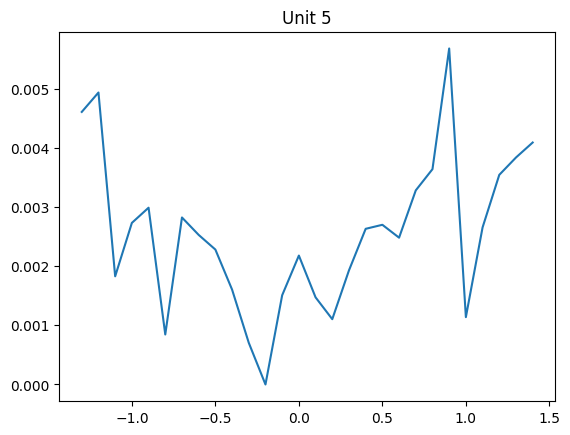

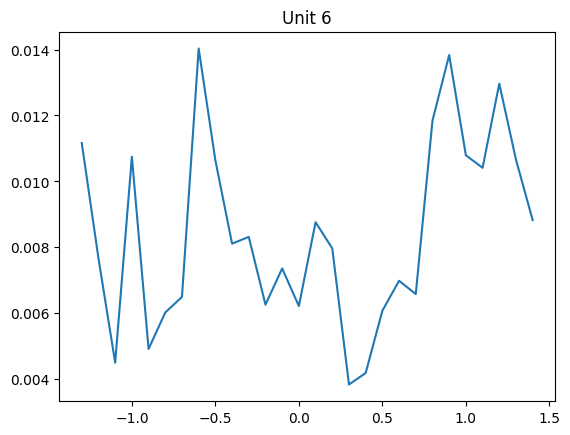

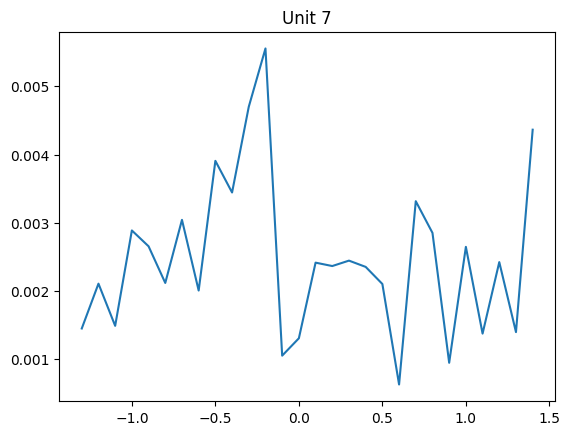

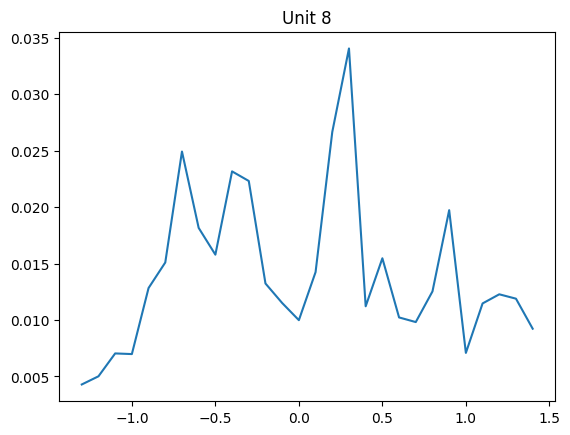

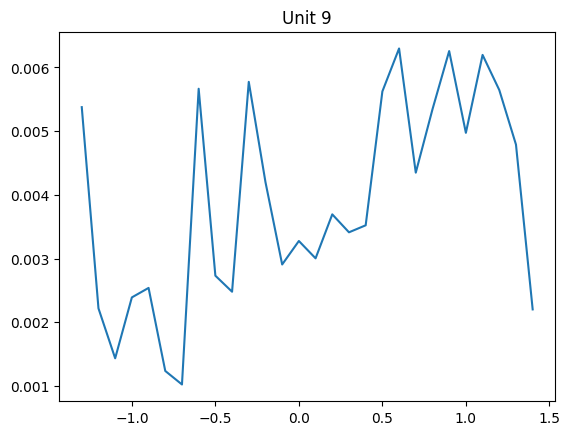

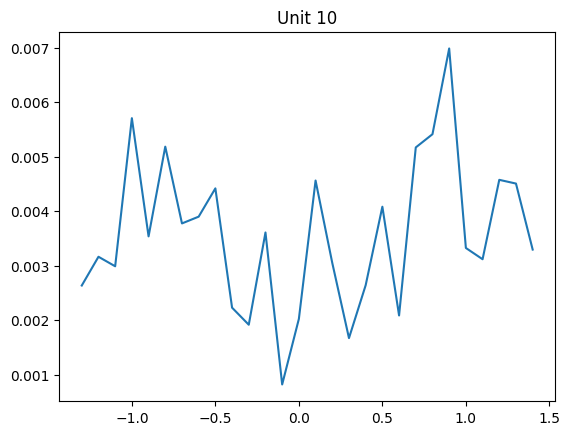

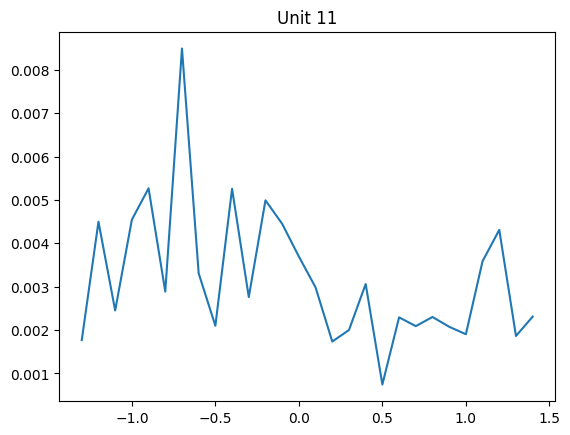

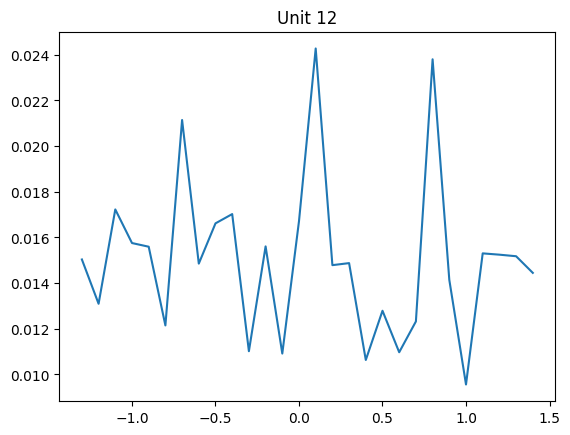

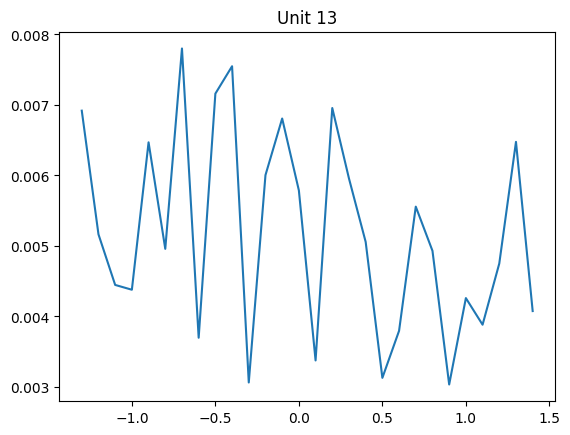

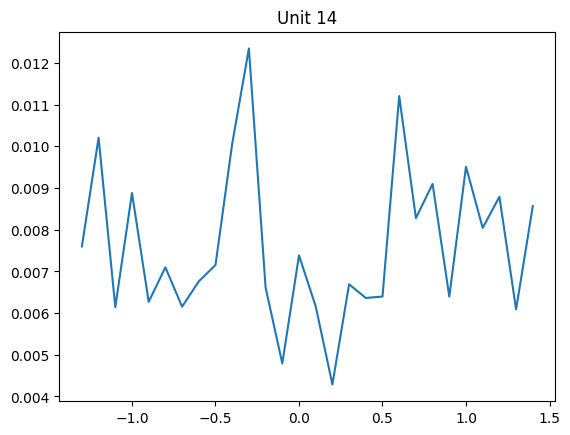

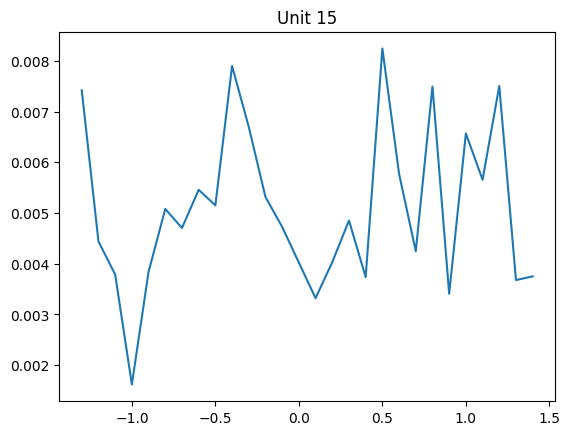

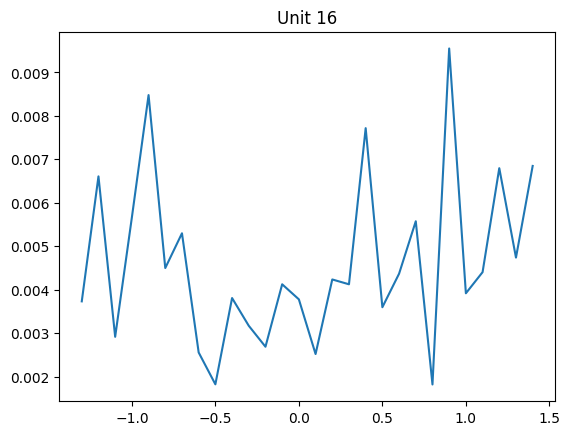

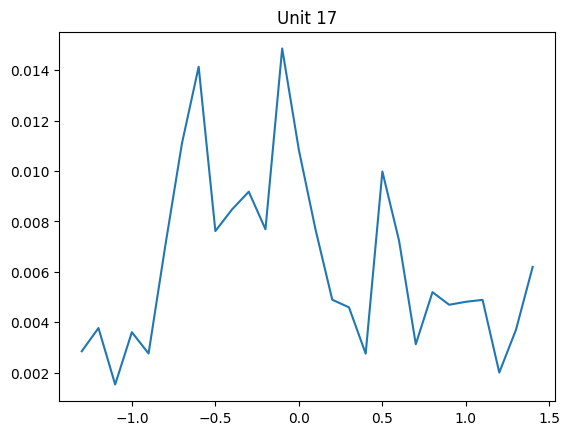

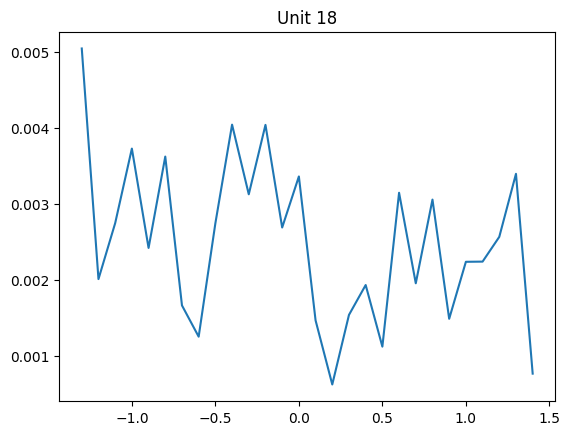

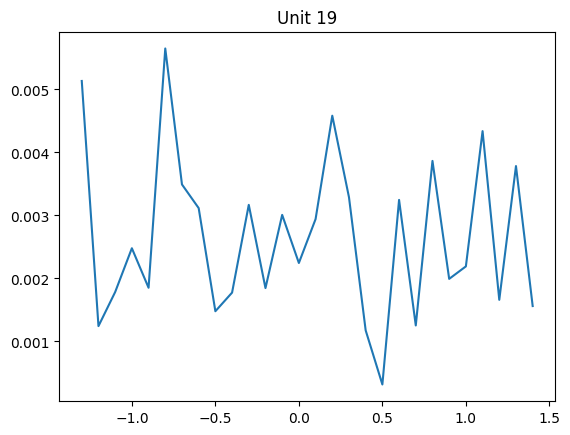

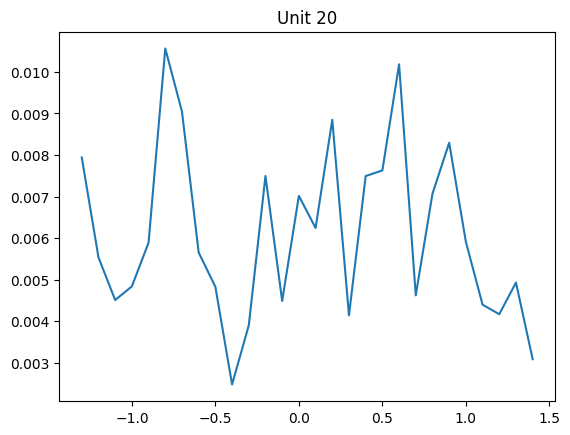

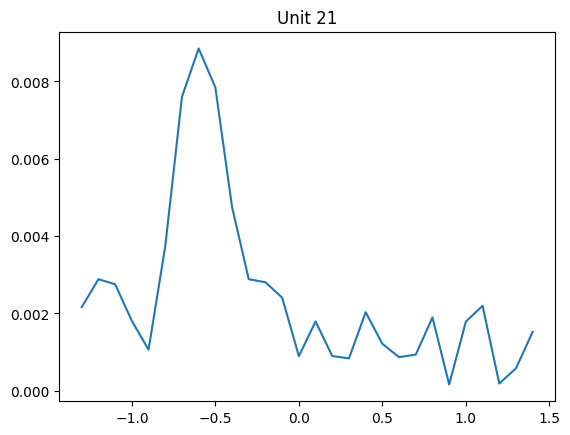

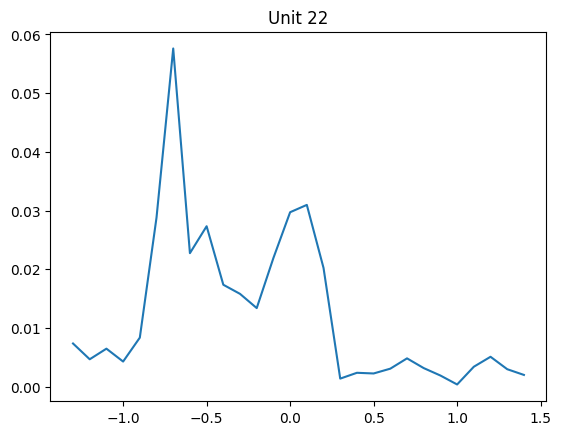

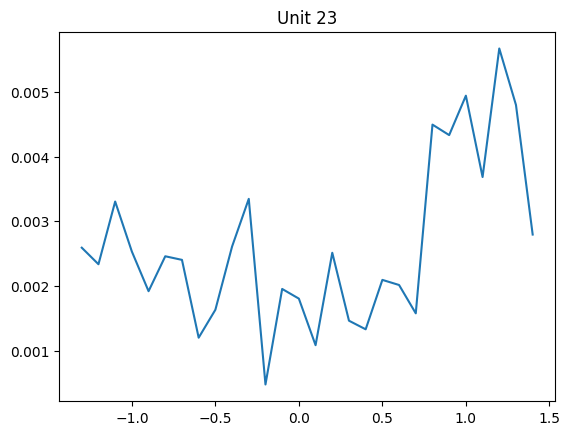

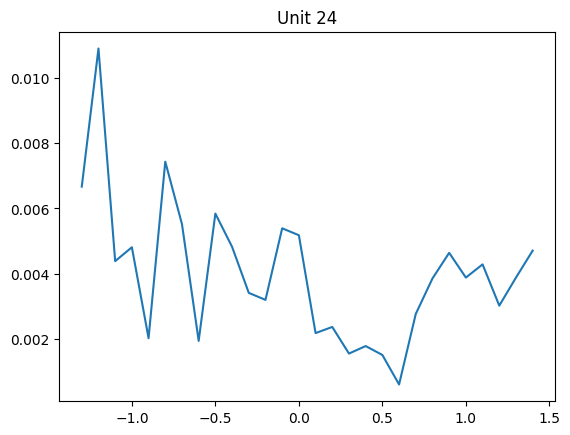

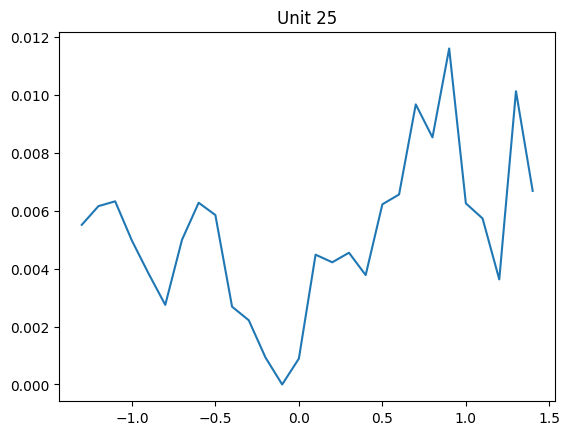

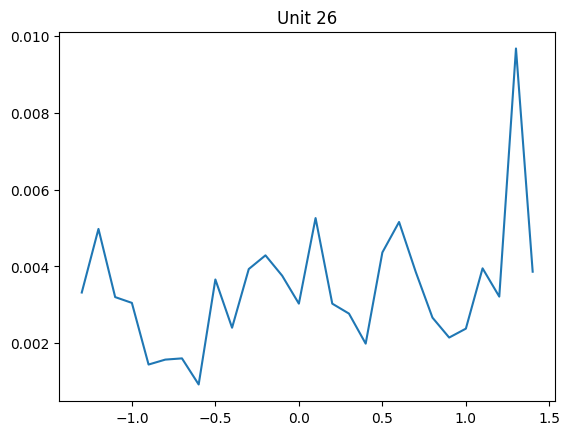

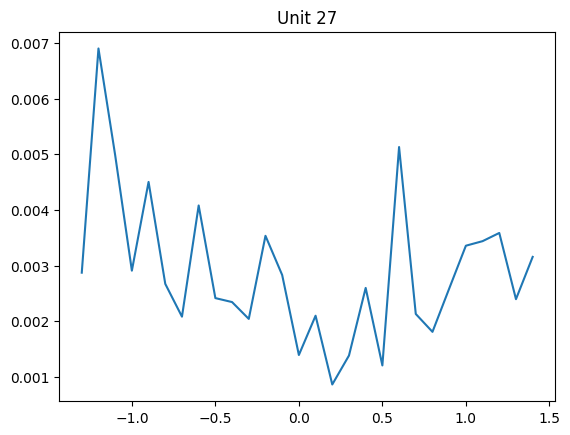

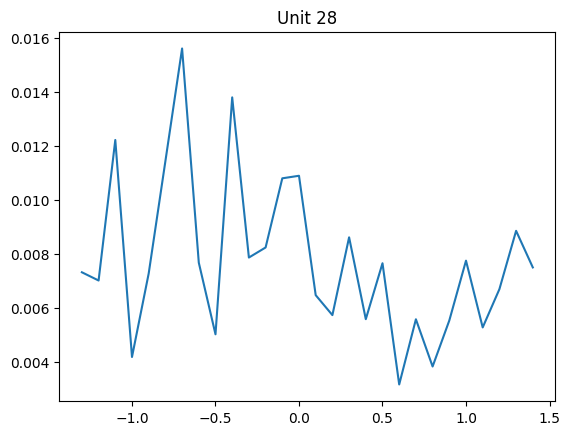

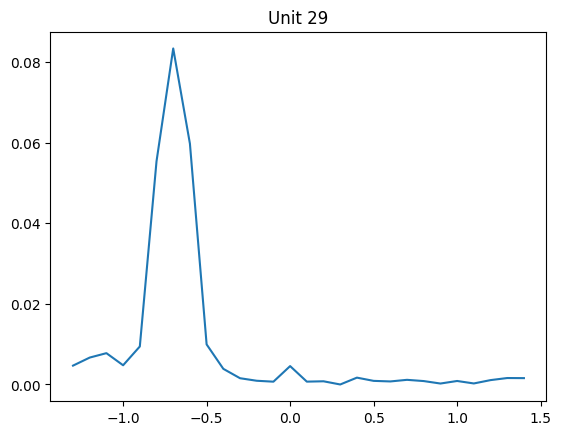

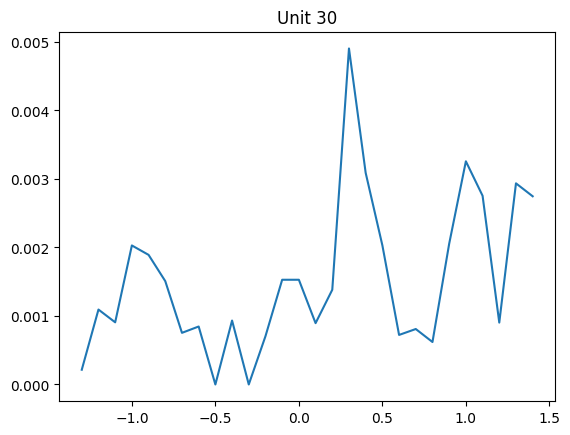

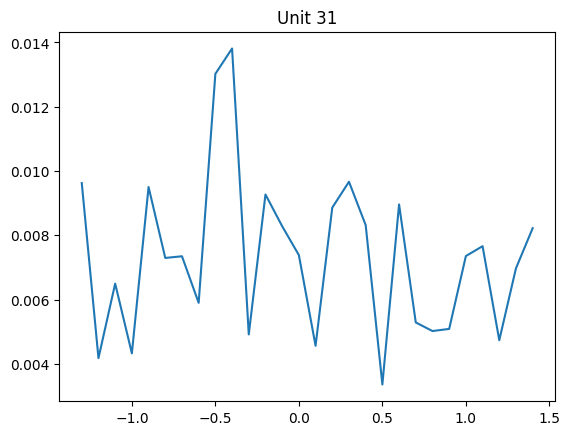

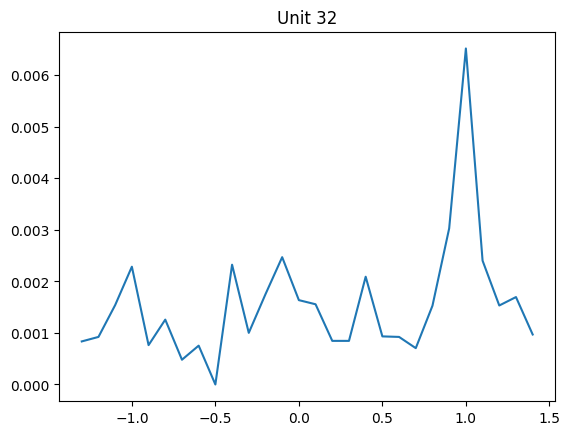

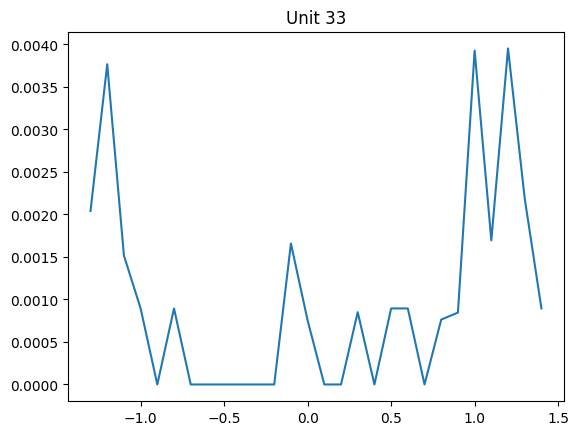

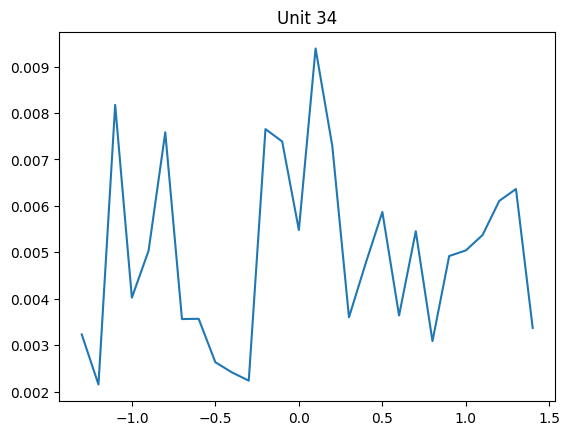

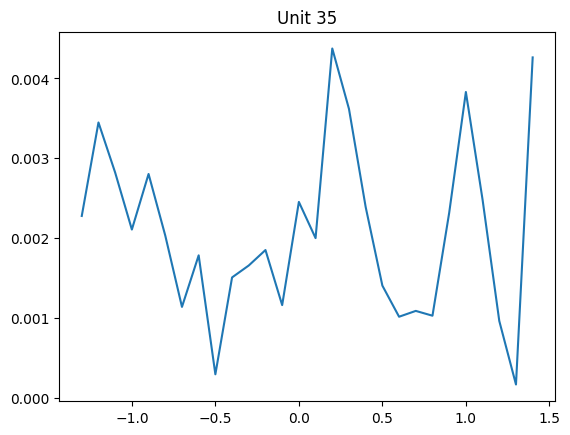

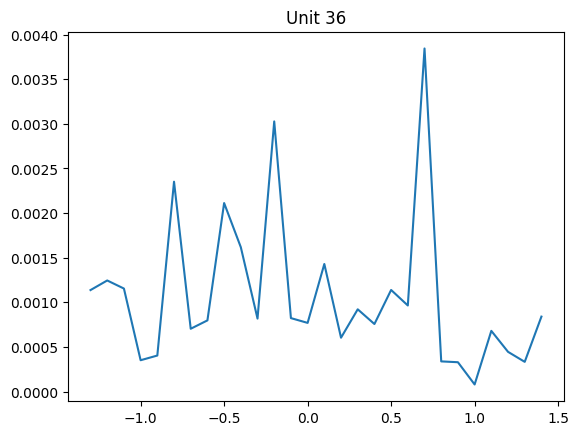

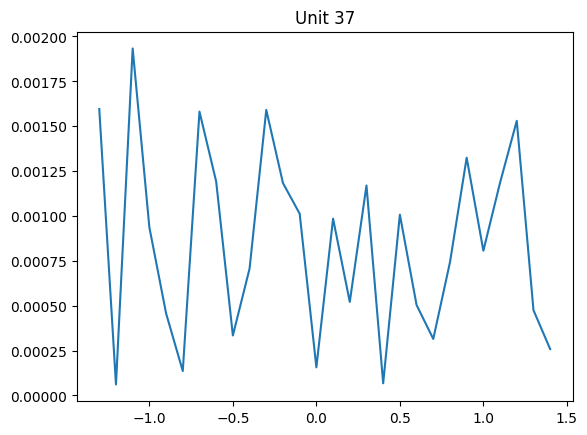

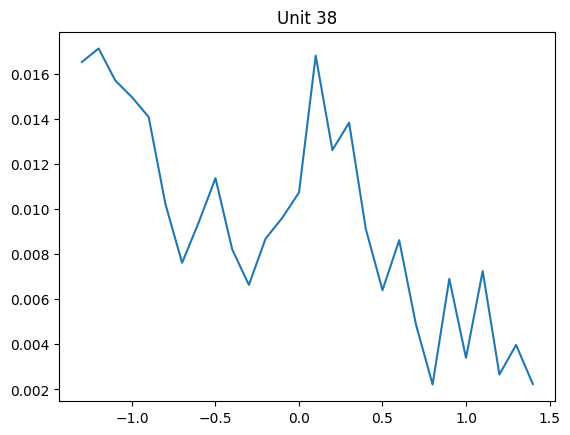

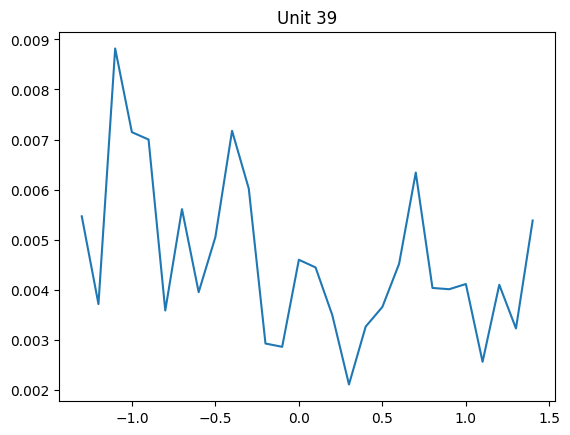

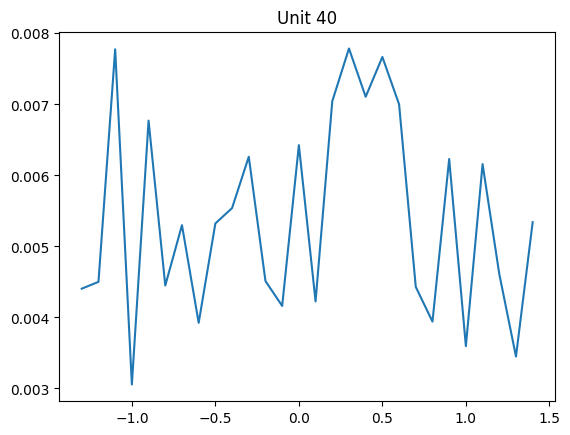

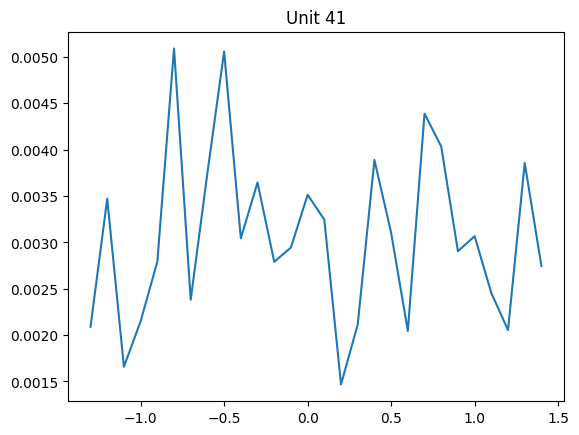

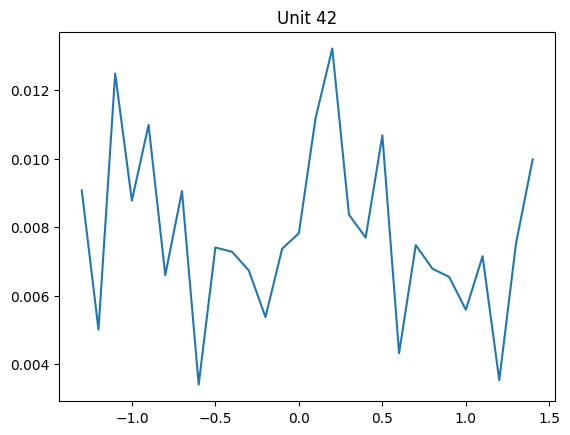

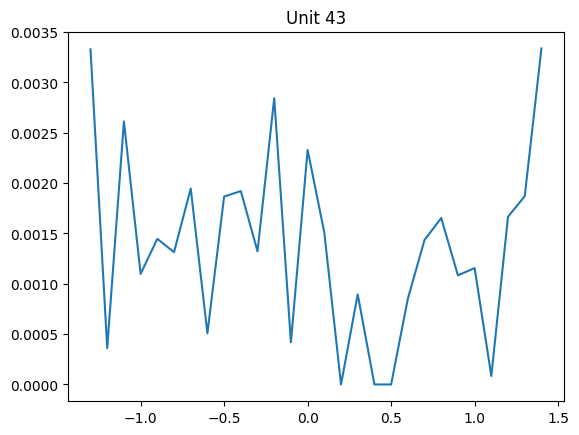

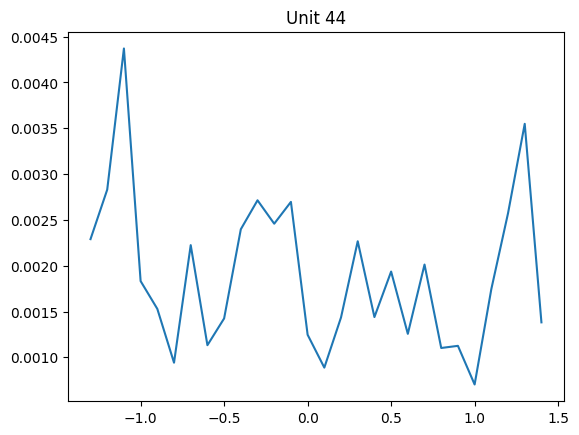

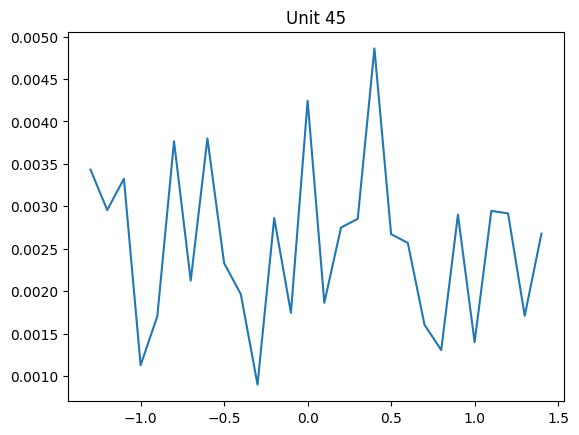

In [10]:
# see if some mutual information metrics look reasonable
for unit in mi.UnitID.unique():
    unit_mi = mi[mi.UnitID == unit]
    time_bins = unit_mi.TimeBins - 1.3
    val = unit_mi.MutualInformation
    fig, ax = plt.subplots()
    ax.plot(time_bins, val)
    ax.set_title(f"Unit {unit}")

In [11]:
feature_dim = "Shape"
mi = calc_mutual_information_per_unit_and_time(data, "SpikeCounts", feature_dim)

/tmp/ipykernel_727255/184920725.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


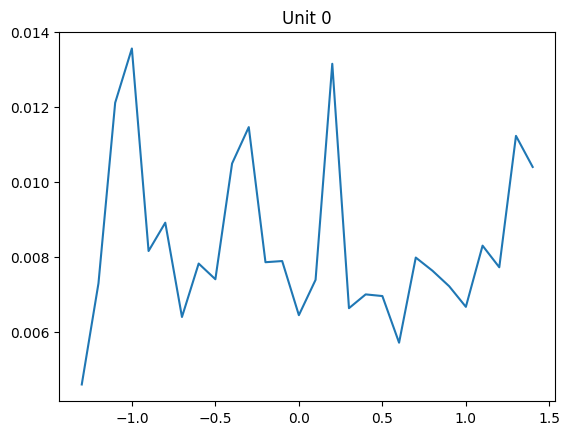

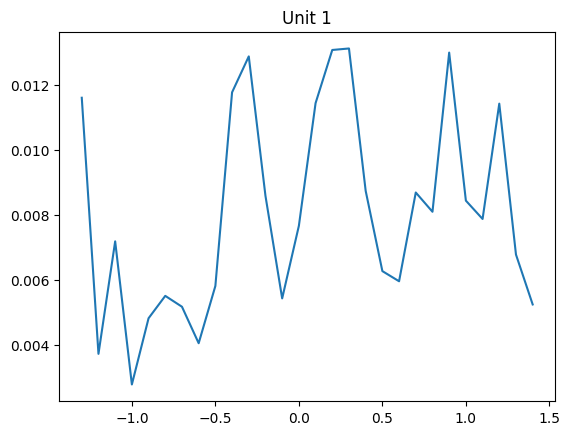

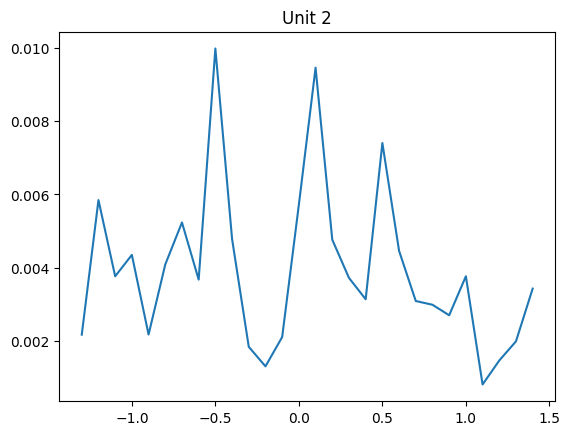

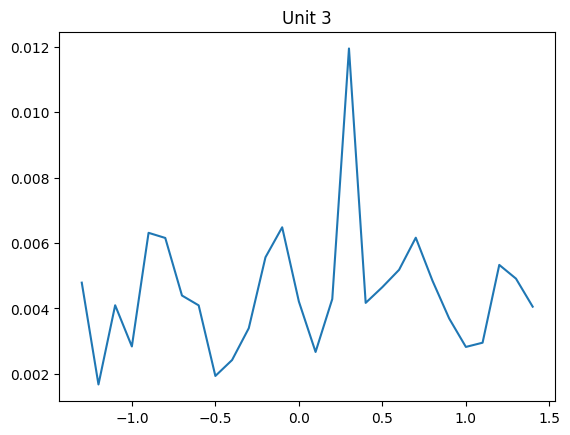

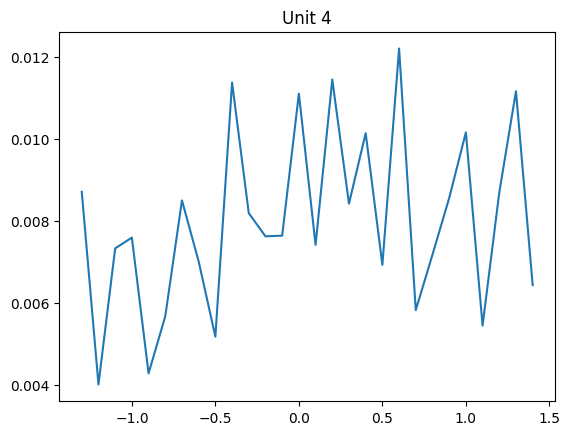

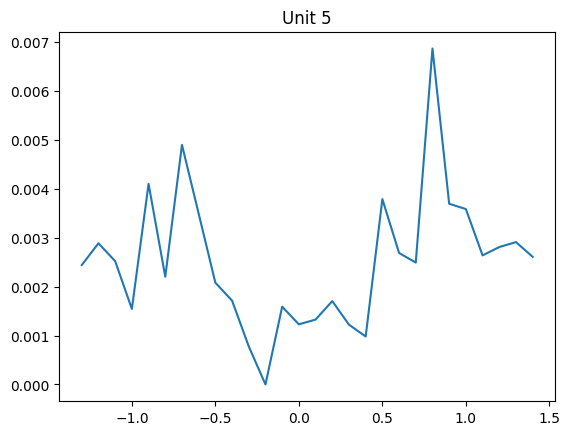

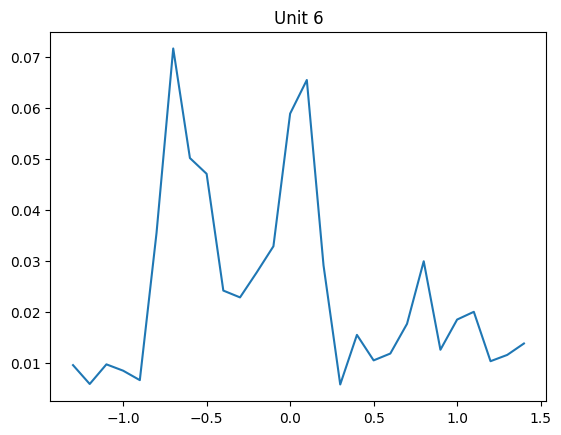

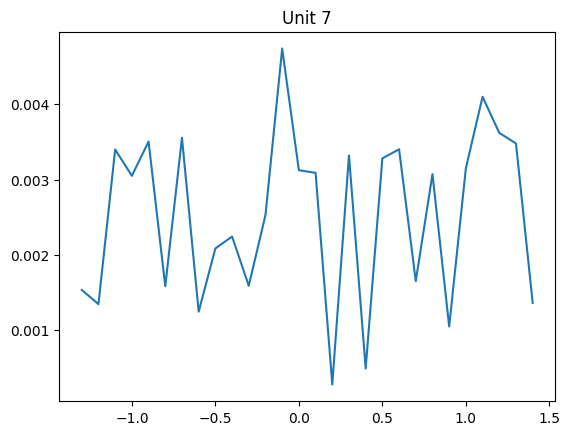

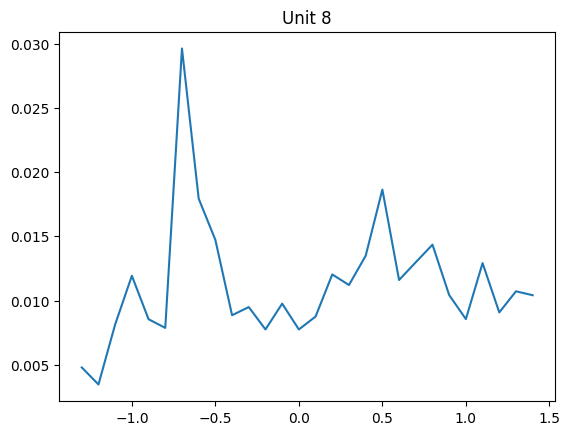

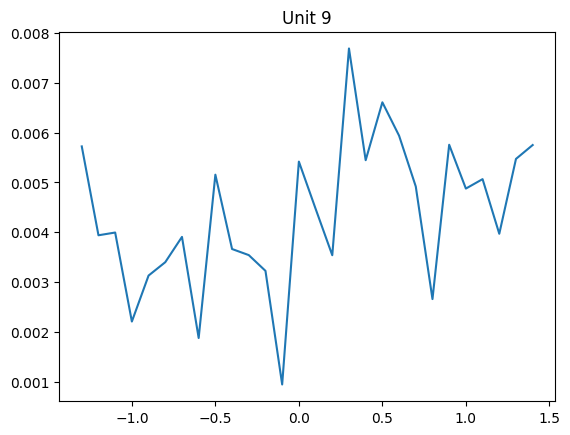

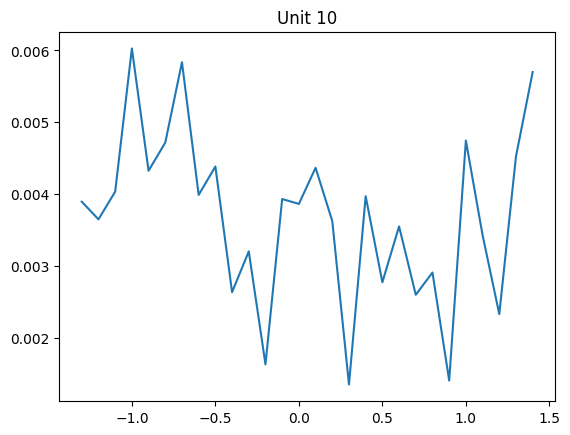

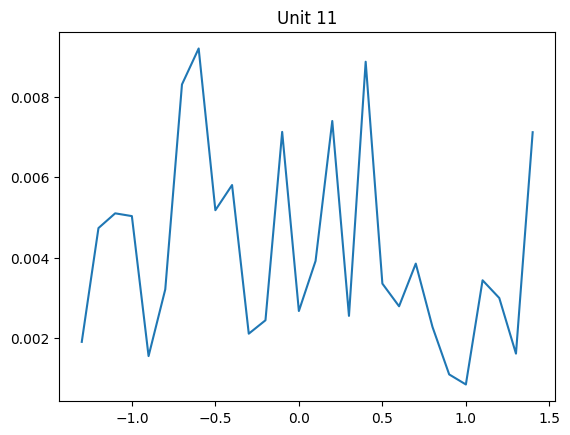

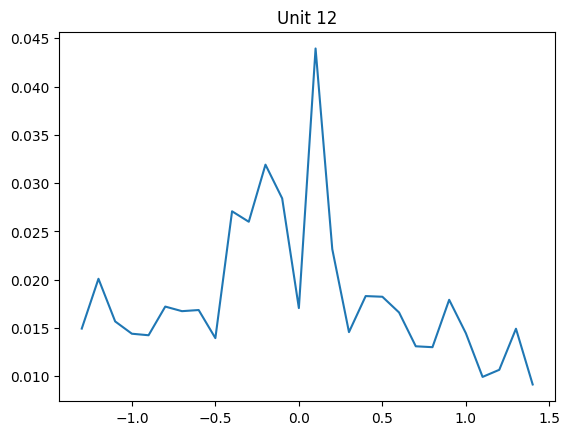

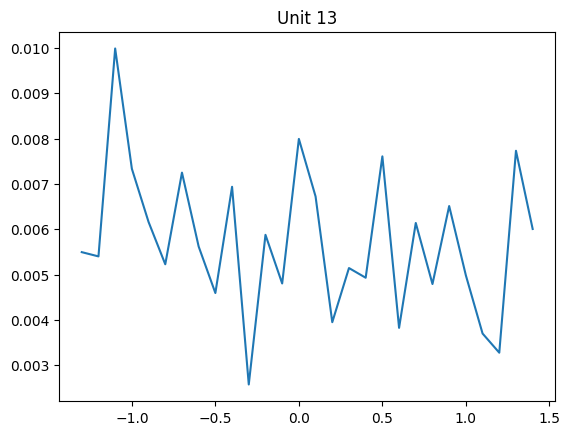

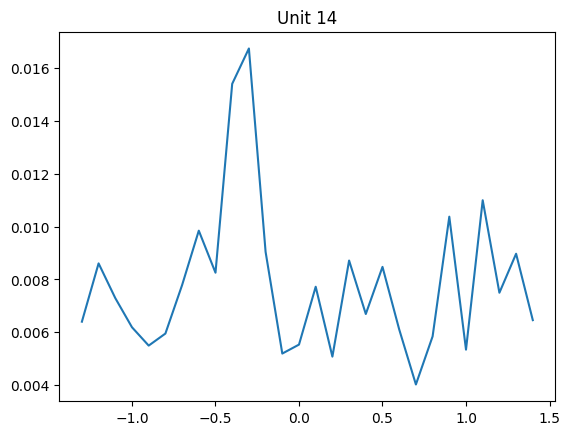

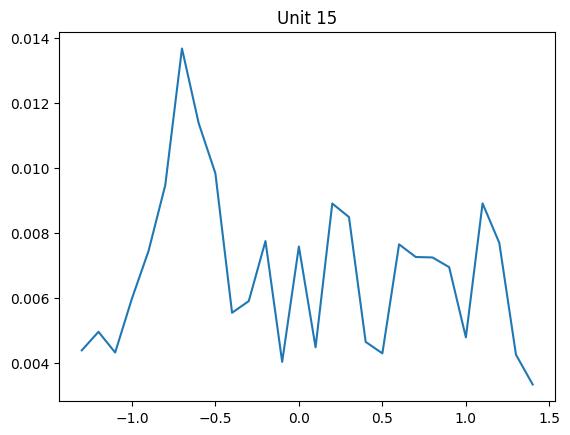

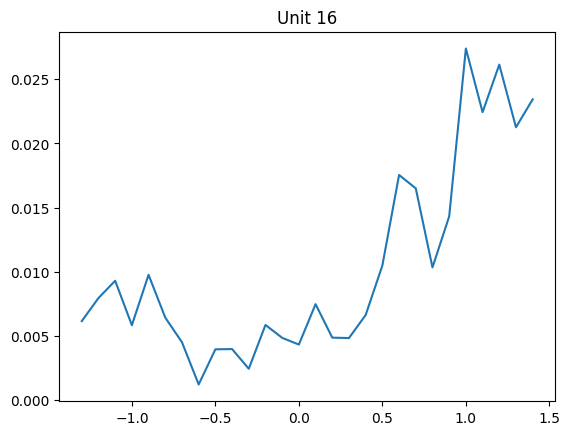

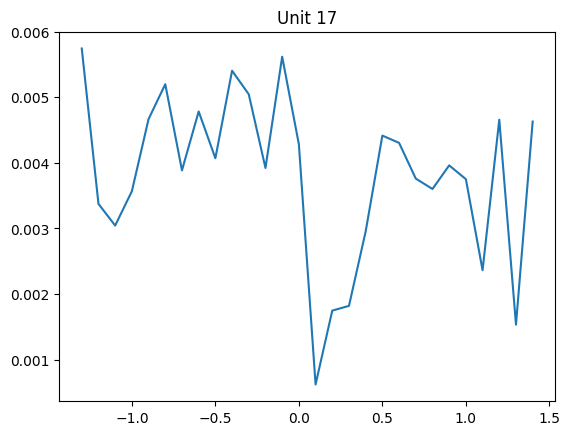

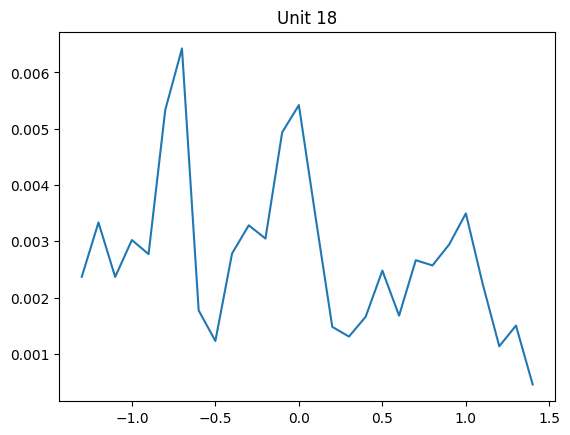

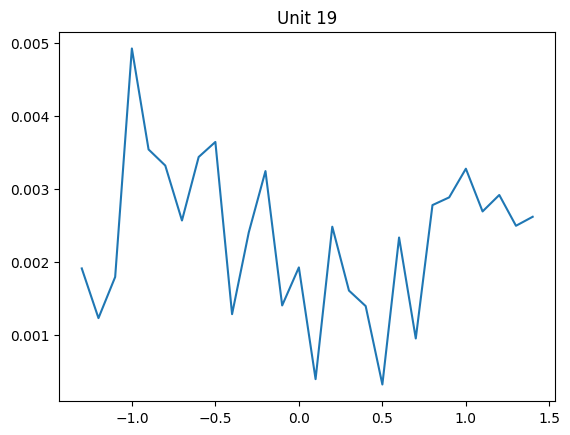

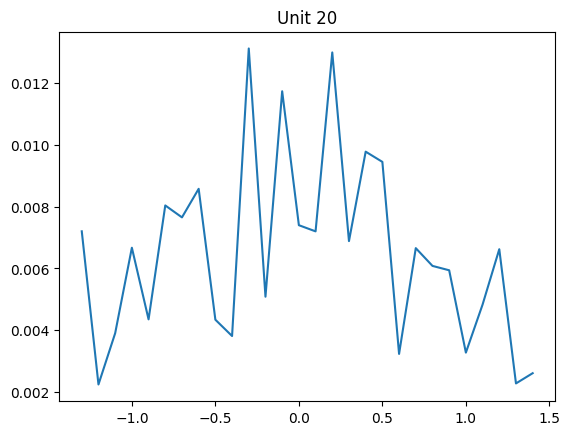

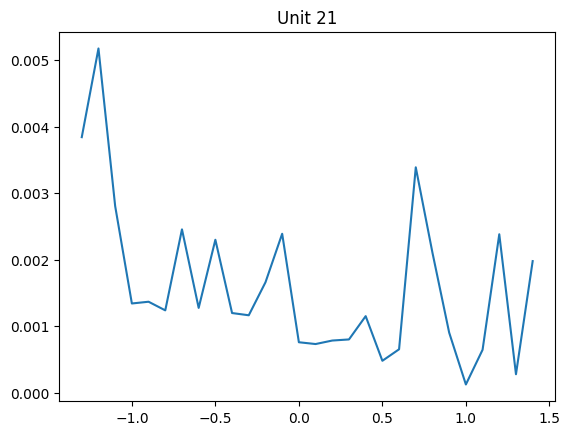

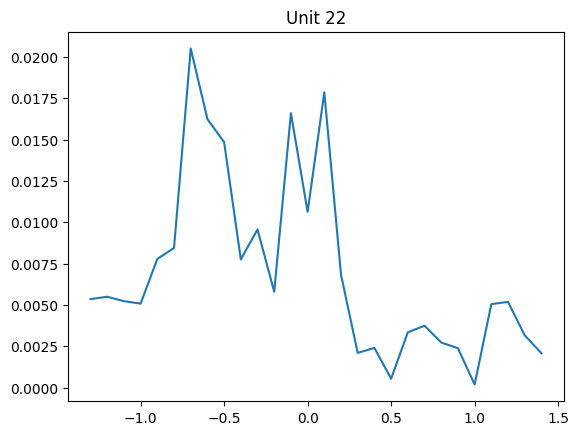

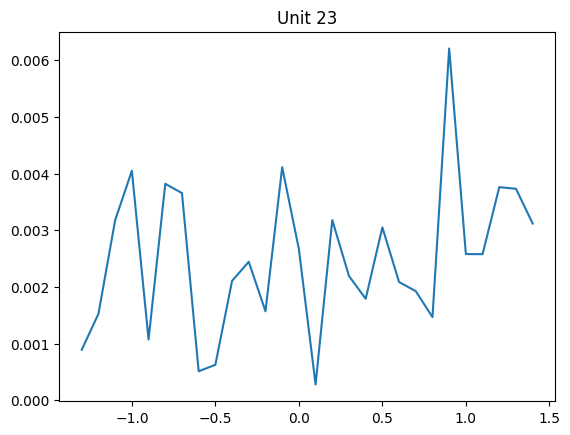

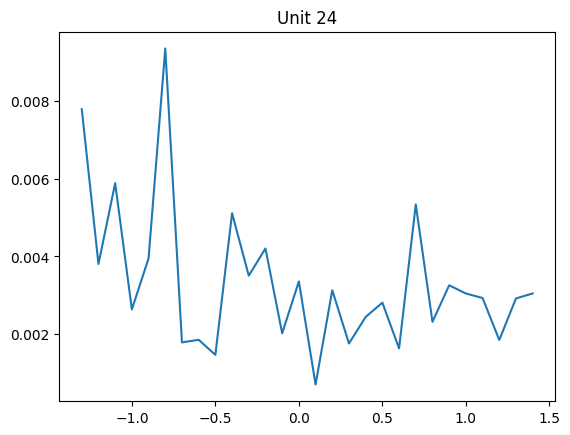

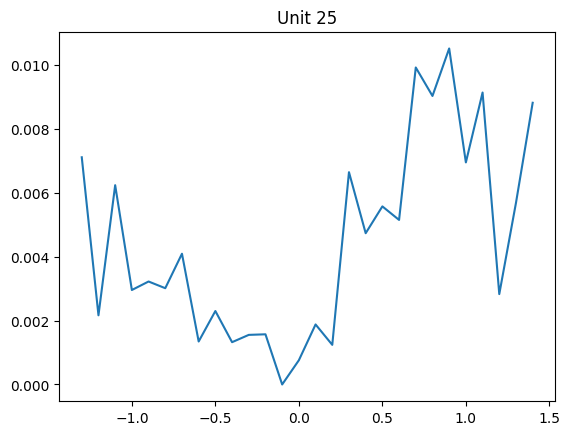

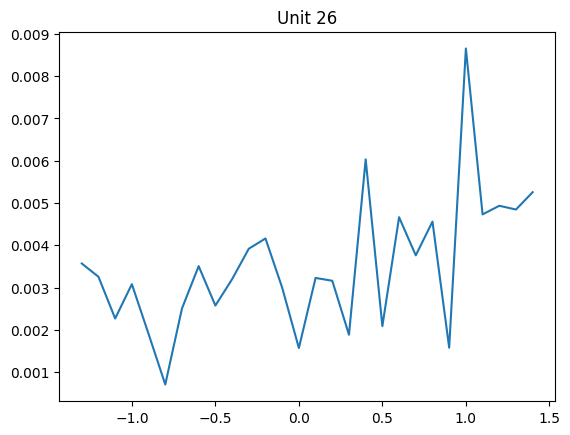

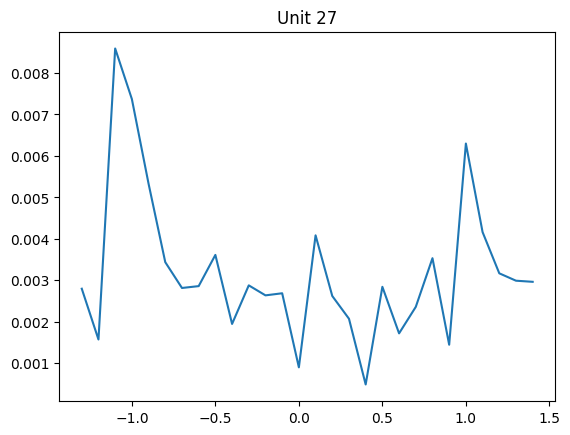

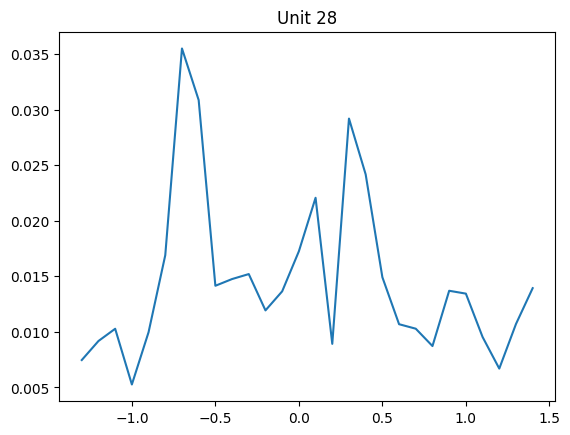

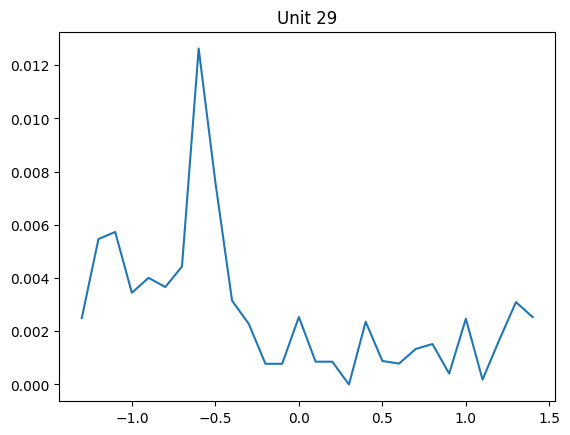

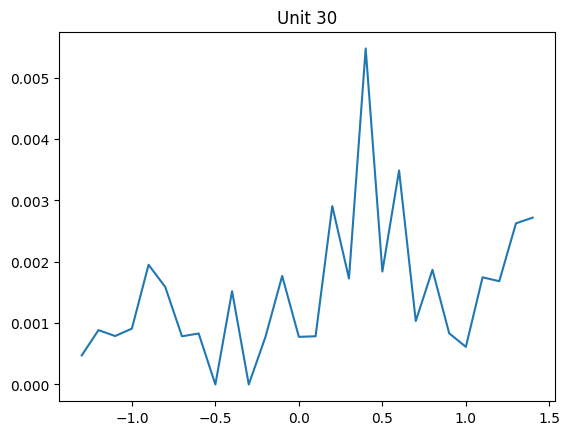

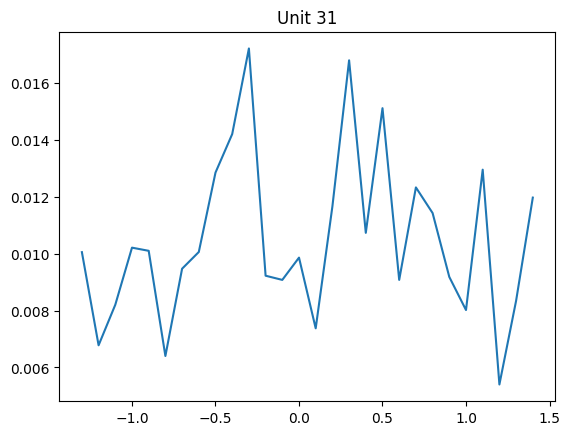

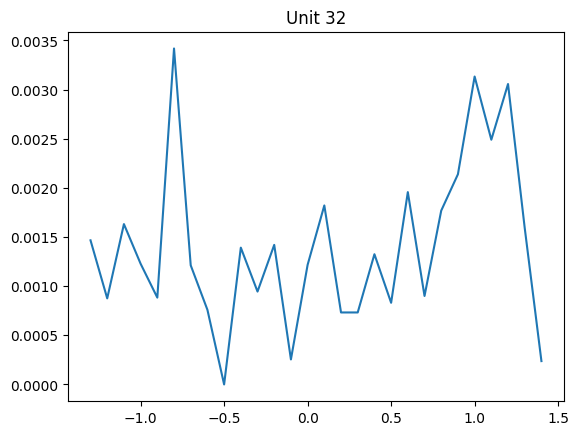

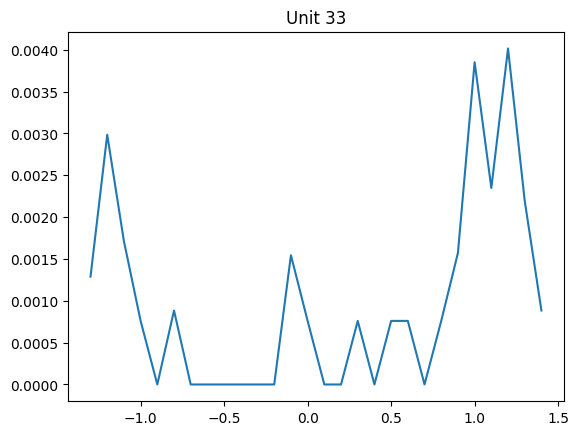

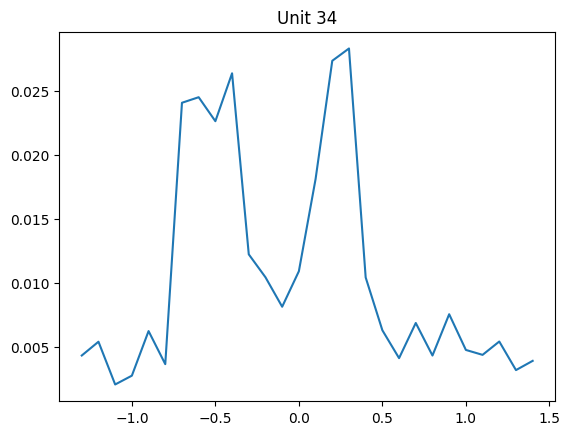

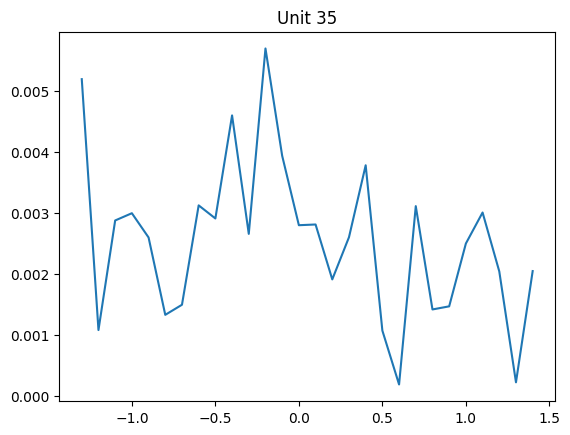

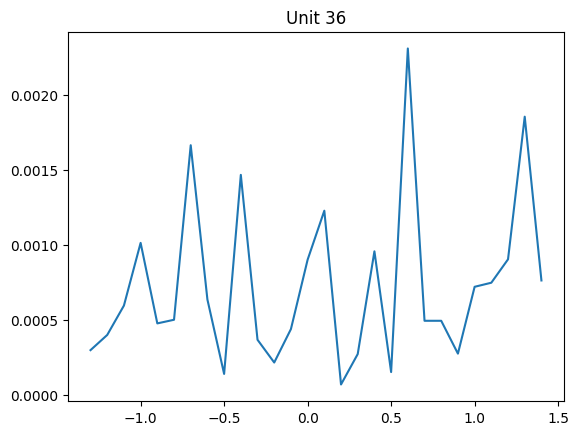

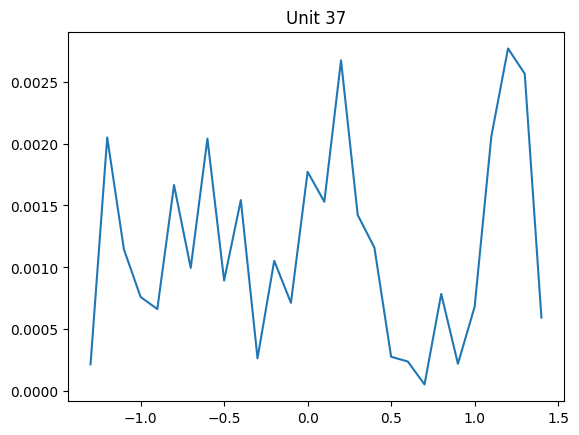

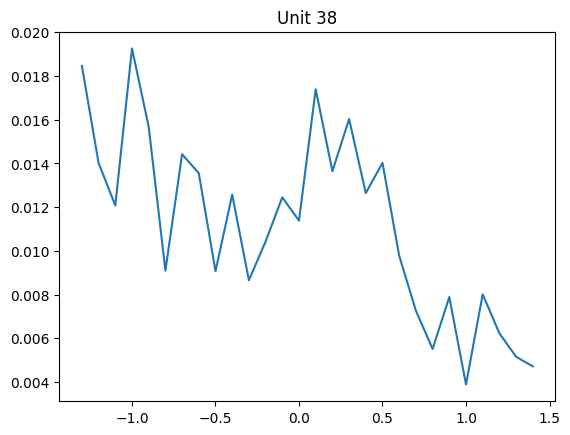

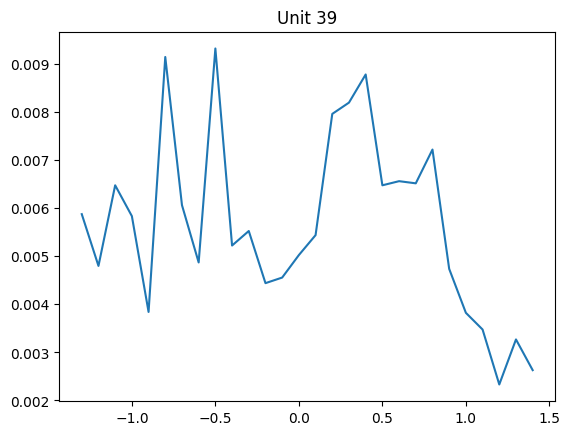

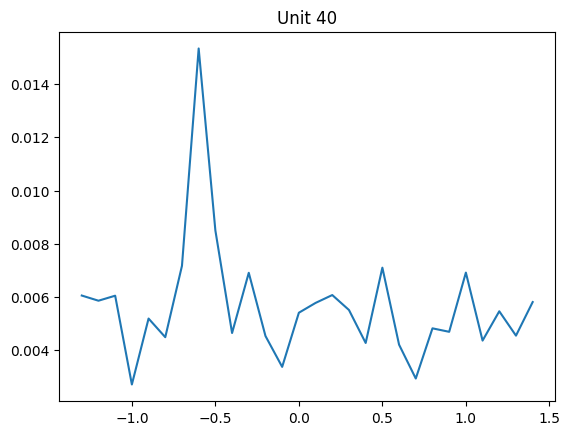

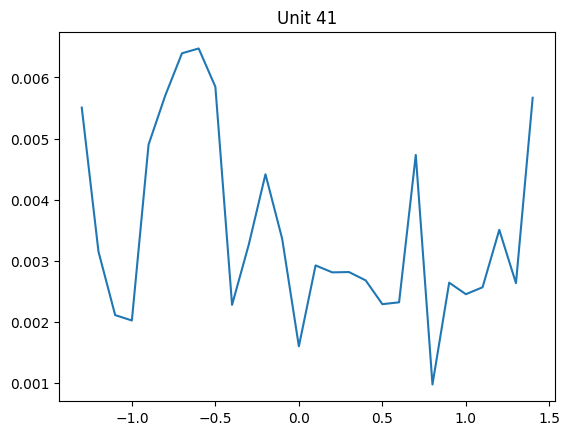

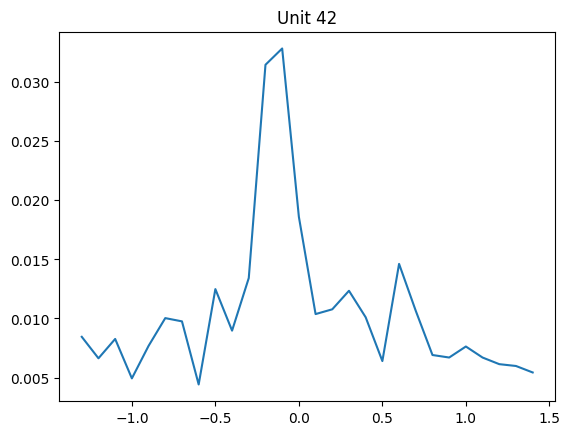

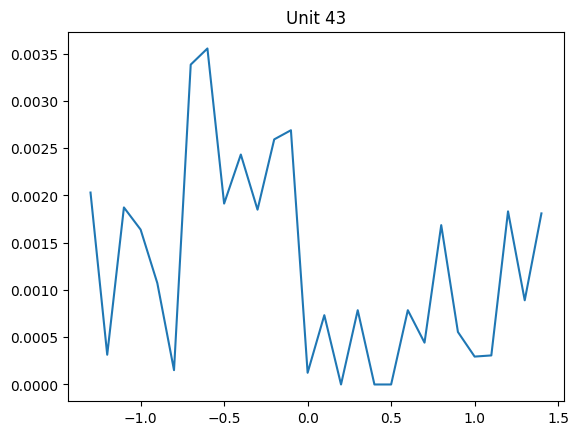

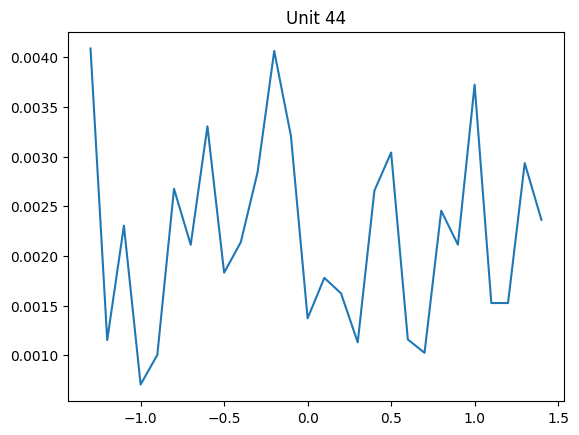

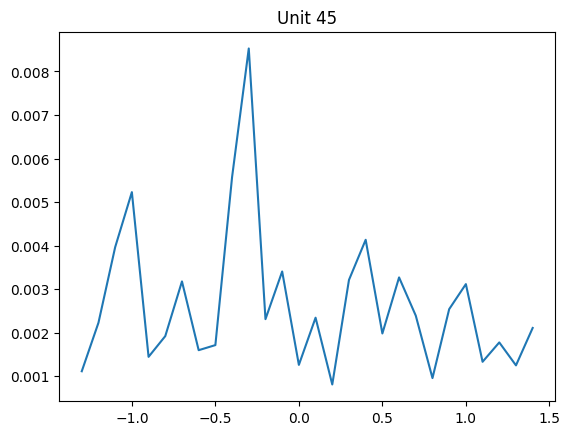

In [12]:
for unit in mi.UnitID.unique():
    unit_mi = mi[mi.UnitID == unit]
    time_bins = unit_mi.TimeBins - 1.3
    val = unit_mi.MutualInformation
    fig, ax = plt.subplots()
    ax.plot(time_bins, val)
    ax.set_title(f"Unit {unit}")